# Workflow

- Dataset Preparation

- Split and Preprocess Data

- Utilities for Metric Evaluation and Plotting

- Hyper-Parameters

- Building Model

- Training

- Testing

- Display performance

# Loading Basic Libraries

In [1]:
import numpy as np
import pandas as pd
import time

In [2]:
%%capture
from tqdm import tqdm_notebook as tqdm_nb
from tqdm import tnrange
tqdm_nb().pandas()

# Dataset Preparation

In [3]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torchvision.transforms.functional as F

In [4]:
train_csv = pd.read_csv("fashion-mnist_train.csv")
test_csv  = pd.read_csv("fashion-mnist_test.csv")

In [5]:
test_csv.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
np.sort(test_csv['label'].unique())

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [7]:
label_names = ['T-Shirt'  , # 0
               'Trouser'  , # 1
               'Pullover' , # 2
               'Dress'    , # 3
               'Coat'     , # 4
               'Sandal'   , # 5
               'Shirt'    , # 6
               'Sneaker'  , # 7
               'Bag'      , # 8
               'Ankle Boot' # 9
              ]

# Preprocessing Data 

In [8]:
class Fashion_MNIST(Dataset):   
    def __init__(self, data, trans = transforms.ToTensor()):
        self.data_ls = list(data.values)
        self.transform = trans
        
        label_ls = []
        image_ls = []
        
        for i in self.data_ls:
            label_ls.append(i[0])
            image_ls.append(i[1:])

        self.labels = np.asarray(label_ls)
        self.images = np.asarray(image_ls).reshape(-1, 28, 28, 1).astype('float32')

    def __getitem__(self, ind):
        label = self.labels[ind]
        img = self.images[ind]
        
        if self.transform is not None:
            img = (self.transform(img).float())
            
        return img, label
    
    def __len__(self):
        return len(self.images)

# Split and Preprocess Data

In [9]:
train_data = Fashion_MNIST(train_csv)
test_data  = Fashion_MNIST(test_csv)

# Data conversion to Torch

In [10]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True);

test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=batch_size,
                                          shuffle=False);

# Utilities for Metric Evaluation and Plotting

In [11]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
%matplotlib inline

from sklearn.metrics import accuracy_score as accuracy

In [12]:
def plot_fn(loss):
    loss = np.array(loss, dtype = np.float)
    plt.plot(loss)

In [13]:
def format_results(epoch  , m_loss , m_acc , v_acc):
    print ( "Epoch: {0:5d},  Mean_Loss : {1:0.4f} ,  Mean_acc : {2:0.4f} ,  Val_accuracy : {3:0.4f}". 
           format(epoch, m_loss , m_acc, v_acc))

In [14]:
def val_metric():
    
    batch_loss = []
    batch_acc  = []
    for batch_num, (batch_x, batch_y) in enumerate(test_loader):
    
        pred_y = model(batch_x)
        loss = loss_fn(pred_y, batch_y)    

        opt_fn.zero_grad()

        loss.backward()
        opt_fn.step()    

        batch_loss.append(loss.item())
        batch_res = np.argmax(pred_y.detach().numpy() , axis = 1)
        batch_acc.append(accuracy(batch_y ,batch_res ))
        
    return np.mean(batch_acc)

In [15]:
sample_loader = torch.utils.data.DataLoader(dataset=train_data + test_data,
                                          batch_size=16,
                                          shuffle=False);

In [16]:
sample_imgs , sample_labels= next(iter(sample_loader))

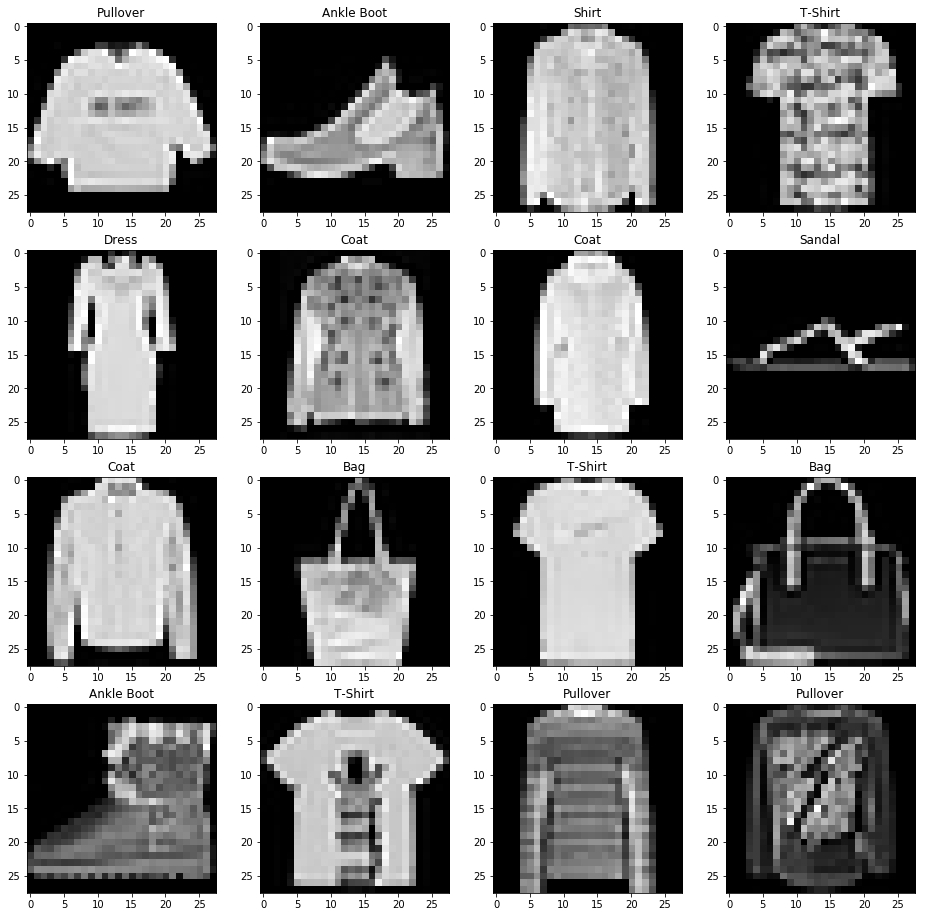

In [17]:
fig = plt.figure(figsize=(16,16));
cols = 4;
rows = 4;

for jj in range(0, len(sample_labels)):
    fig.add_subplot(rows, cols, jj + 1)
    plt.title(label_names[sample_labels[jj]])
    plt.imshow(sample_imgs[jj].squeeze(), cmap='gray')
plt.show()  

# Hyper Parameters

Change values in the followng sections to see how the accuracy can be increased

In [18]:
num_epoch = 3
per_epoch = int( num_epoch / 3)
lr = 0.001

In [19]:
num_features = 1  # Dimension of input features
num_classes  = 10  # Dimension of output

In [20]:
# Try various activation functions
actv_func = nn.ReLU()

In [21]:
# No of hidden layers and their size
h_layers = [ 16 , 32 ]     # Trial 1
# h_layers = [ ]         # Trial 2

# Building Model

In [22]:
def Create_hidden(h_layers):
    layers = []
    input_num = num_features
    
    for h in h_layers:
        output_num = h
        layers.append ( nn.Conv2d(input_num , output_num , kernel_size=5, padding=2) ) 
        layers.append ( nn.BatchNorm2d( output_num) ) 
        layers.append ( actv_func )
        layers.append ( nn.MaxPool2d(2) )
        input_num = h
        
    #layers.append ( nn.Linear(input_num , num_classes) ) 
    net = nn.Sequential(*layers)
    return net

In [24]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.net = Create_hidden(h_layers)
        self.fc = nn.Linear(7*7*32, 10)
        
    def forward(self,x):
        feature = self.net(x)
        feature = feature.view(feature.size(0), -1)
        y = self.fc(feature)
        
        return y
model =    Classifier()

Classifier(
  (net): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)

In [ ]:
model

In [27]:
loss_fn = nn.CrossEntropyLoss();
opt_fn = torch.optim.Adam(model.parameters(), lr=lr);

# Training

In [28]:
loss_array = []

for epoch in tnrange(num_epoch):
    
    batch_loss = []
    batch_acc  = []
    for batch_num, (batch_x, batch_y) in enumerate(train_loader):
    
        pred_y = model(batch_x)
        loss = loss_fn(pred_y, batch_y)    

        opt_fn.zero_grad()

        loss.backward()
        opt_fn.step()    

        batch_loss.append(loss.item())
        batch_res = np.argmax(pred_y.detach().numpy() , axis = 1)
        batch_acc.append(accuracy(batch_y ,batch_res ))
        
    mean_loss = np.mean(batch_loss)
    mean_acc = np.mean(batch_acc)
    
    loss_array.append(mean_loss)

    res_y = np.argmax(pred_y.detach().numpy() , axis = 1)
    
    if (epoch) % per_epoch == 0:
        format_results( epoch+1 , mean_loss , mean_acc , val_metric() )

Epoch:     1,  Mean_Loss : 0.4101 ,  Mean_acc : 0.8546 ,  Val_accuracy : 0.8929
Epoch:     2,  Mean_Loss : 0.2823 ,  Mean_acc : 0.8988 ,  Val_accuracy : 0.9092
Epoch:     3,  Mean_Loss : 0.2498 ,  Mean_acc : 0.9095 ,  Val_accuracy : 0.9177



# Testing

In [29]:
model.eval()

Classifier(
  (net): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)

In [30]:
sample_imgs , sample_labels= next(iter(sample_loader))

In [31]:
num = 1

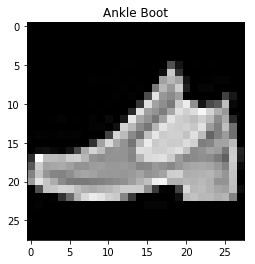

In [32]:
plt.title(label_names[sample_labels[num]])
plt.imshow(sample_imgs[num].squeeze(), cmap='gray')

In [33]:
def predict_single_data(model , data):
    pred_y = model(data.unsqueeze(0))
    res_y = np.argmax(pred_y.detach().numpy() , axis = 1)
    return res_y[0]

In [34]:
res_test = predict_single_data(model , sample_imgs[num])
print(label_names[res_test])

Ankle Boot
